Authors:
* Duhr Łukasz, indeks: 136700
* Komkowska Ewa, indeks: 136737

## Loading from file

### Install libraries and read files

In [ ]:
!pip install tspy
!pip install TSPLib95

import tsplib95
import numpy as np
import matplotlib.pyplot as plt
from tspy import TSP
from random import randint

In [ ]:
tsp = TSP()

kroAProblem = tsplib95.load('kroA100.tsp')
kroBProblem = tsplib95.load('kroB100.tsp')

kroAData = kroAProblem.as_name_dict()['node_coords']
kroBData = kroBProblem.as_name_dict()['node_coords']

verticesA = [kroAData[key] for key in kroAData]
verticesB = [kroBData[key] for key in kroBData]

### Convert data to distance matrix

In [ ]:
def distance_matrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]

  return np.array(outputMatrix)

In [ ]:
print(distance_matrix(verticesA))
print(distance_matrix(verticesB))

[[   0 1693 2252 ...  783 1468 2643]
 [1693    0 1708 ... 1911 3156 1831]
 [2252 1708    0 ... 1786 3315  454]
 ...
 [ 783 1911 1786 ...    0 1535 2228]
 [1468 3156 3315 ... 1535    0 3760]
 [2643 1831  454 ... 2228 3760    0]]
[[   0 2607  549 ...  229  618 1249]
 [2607    0 3154 ... 2621 3075 2661]
 [ 549 3154    0 ...  571  403 1499]
 ...
 [ 229 2621  571 ...    0  480 1475]
 [ 618 3075  403 ...  480    0 1796]
 [1249 2661 1499 ... 1475 1796    0]]


## Algorithms

### Utility


In [ ]:
def choose_nearest(matrix, invited_vertices, node):
  return np.argmin([matrix[node][i] if i not in invited_vertices and i != node else float('inf') for i in range(0, len(matrix[node]))])

In [ ]:
def calculate_cycle_length(matrix, visited):
  sum = 0
  for graph in visited:
    sum += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])
  return sum

In [ ]:
def draw_plot(vertices, visited):
  for graph in visited:
    x = [vertices[idx][0] for idx in graph]
    y = [vertices[idx][1] for idx in graph]
    plt.plot(x, y)
  plt.show()

### Greedy algorithm (using nearest neighbor)

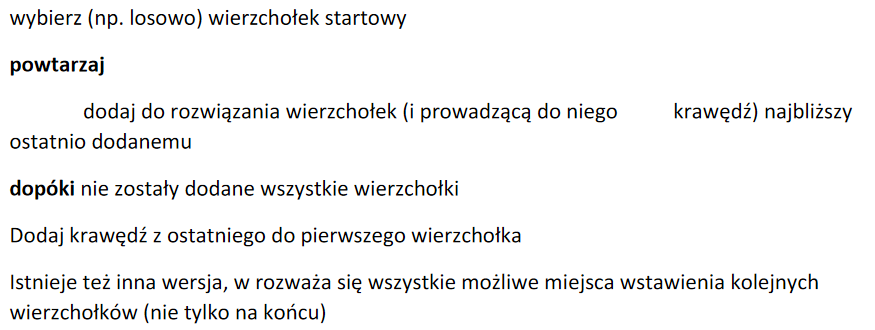

In [ ]:
def greedy_nearest_neighbor(distance_matrix, start_node_1):

  # Get indexes of two starting nodes
  node_1 = start_node_1
  node_2 = np.argmax(matrix[node_1])

  visited_1 = [node_1]
  visited_2 = [node_2]

  while len(np.concatenate([visited_1, visited_2])) != len(matrix):
    if len(visited_1) <= len(visited_2):
      vertex = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_1)
      visited_1.append(vertex)
      node_1 = vertex
    else:
      vertex = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_2)
      visited_2.append(vertex)
      node_2 = vertex

  visited_1.append(visited_1[0])
  visited_2.append(visited_2[0])

  return visited_1, visited_2

  # sum of both cycle
  # print(sum([(matrix[elem][visited_1[i+1]]) for i, elem in enumerate(visited_1[:-1])]) + sum([(matrix[elem][visited_1[i+1]]) for i, elem in enumerate(visited_1[:-1])]))

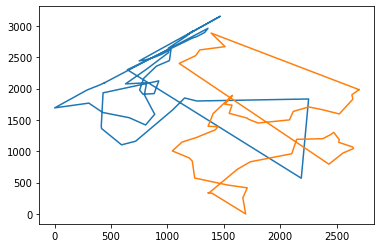

In [ ]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
sum = calculate_cycle_length(matrix, [visited_1, visited_2])
draw_plot(matrix, [visited_1, visited_2])

### Greedy algorithm (using greedy cycle)

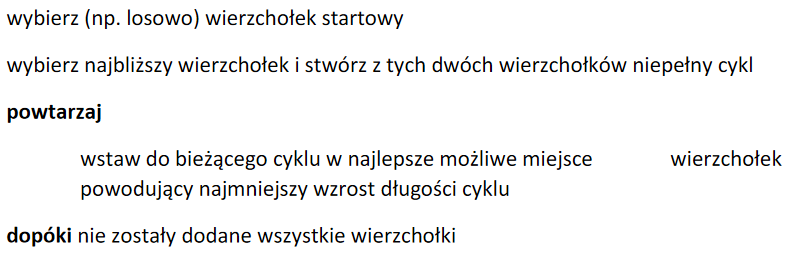

In [ ]:
def greedy_cycle(matrix, start_node_1):
  # Get indexes of two starting nodes
  node_1 = start_node_1
  node_2 = np.argmax(matrix[node_1])

  # Choose nearest vertices
  min_node_1 = choose_nearest(matrix, [node_1, node_2], node_1)
  min_node_2 = choose_nearest(matrix, [node_1, node_2, min_node_1], node_2)

  visited_1 = [node_1, min_node_1, node_1]
  visited_2 = [node_2, min_node_2, node_2]

  # Find min length in visited vertices until visited all
  while len(np.concatenate([visited_1, visited_2])) != len(matrix):
    min_value = np.inf
    min_index = np.inf
    min_closest_index = np.inf

    visited_list = visited_1 if len(visited_1) <= len(visited_2) else visited_2

    for index in range(len(visited_list) - 1):
      closest = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), visited_list[index])
      for index_2 in range(len(visited_list) - 1):

        fix = matrix[visited_list[index_2], closest] + matrix[visited_list[index_2 + 1], closest] - matrix[visited_list[index_2], visited_list[index_2 + 1]]
        if (fix < min_value):
          min_value = fix
          min_index = index_2 + 1
          min_closest_index = closest

    if len(visited_1) <= len(visited_2):
      visited_1 = np.insert(visited_list, min_index, min_closest_index)
    else:
      visited_2 = np.insert(visited_list, min_index, min_closest_index)

  return visited_1, visited_2

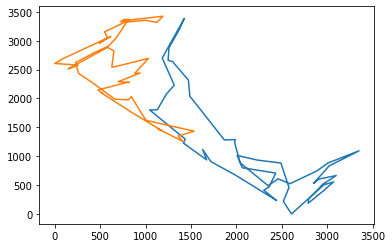

In [ ]:
matrix = distance_matrix(verticesB)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_cycle(matrix, start_node_1)
sum = calculate_cycle_length(matrix, [visited_1, visited_2])
draw_plot(matrix, [visited_1, visited_2])

### Regret heuristic (using 2-regret)

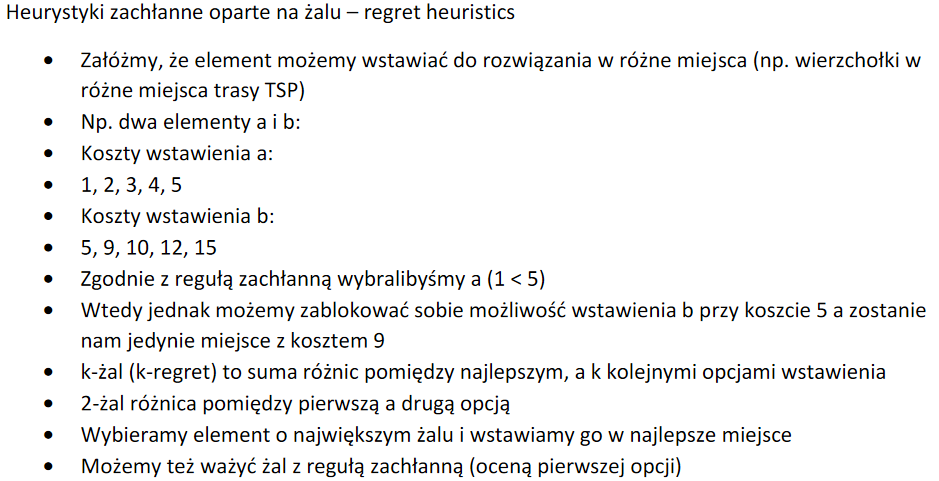

In [ ]:
from heapq import nsmallest

def greedy_regret(matrix, start_node_1):
  # Get indexes of two starting nodes
  node_1 = start_node_1
  node_2 = np.argmax(matrix[node_1])

  # Check as visited
  visited_1 = [node_1]
  visited_2 = [node_2]

  # Choose nearest vertices
  min_node_1 = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_1)
  visited_1.append(min_node_1)

  min_node_2 = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_2)
  visited_2.append(min_node_2)

  visited_1.append(node_1)
  visited_2.append(node_2)

  # print(visited_1, visited_2)


  while len(np.concatenate([visited_1, visited_2])) != len(matrix):
    max_regret = -float('inf') 
    regret_vertice = None

    visited_list = visited_1 if len(visited_1) <= len(visited_2) else visited_2
    start_regret_first = None
    start_regret_second = None

    for index in range(len(matrix)):
      if index not in np.concatenate([visited_1, visited_2]):
        cost_list = []
        for visited_index, visited_vertex in enumerate(visited_list):
          if visited_index + 1 < len(visited_list):
            cost_list.append(matrix[index][visited_vertex] + matrix[index][visited_list[visited_index + 1]] - matrix[visited_vertex][visited_list[visited_index + 1]])
        
        if start_regret_first is None:
          start_regret_first = np.argmin(cost_list)
          start_regret_second = cost_list.index(nsmallest(2, cost_list)[-1])

        if cost_list[start_regret_first] - cost_list[start_regret_second] > max_regret: 
          regret_vertice = index
          max_regret = cost_list[start_regret_first] - cost_list[start_regret_second]

    min_route = np.inf
    index_from = None
    for index, vertex in enumerate(visited_list):
      if index + 1 < len(visited_list) and matrix[regret_vertice][vertex] + matrix[regret_vertice][visited_list[index + 1]] < min_route:
        min_route = matrix[regret_vertice][vertex] + matrix[regret_vertice][visited_list[index + 1]]
        index_from = index + 1
      
    if len(visited_1) <= len(visited_2):
        visited_1.insert(index_from, regret_vertice)
    else:
        visited_2.insert(index_from, regret_vertice)
    
  return visited_1, visited_2

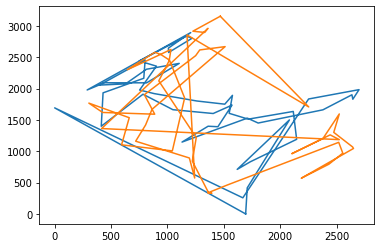

In [ ]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_regret(matrix, start_node_1)
sum = calculate_cycle_length(matrix, [visited_1, visited_2])
draw_plot(matrix, [visited_1, visited_2])

## Tests (x 100)

### Testy dla nearest neighbor

Min_value : 27208
Max_value : 35514
Average : 32496.56
Calculated min:  27208


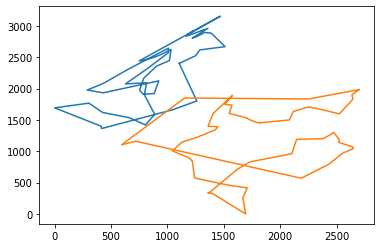

In [ ]:
values = []
min_value = np.inf
max_value = -np.inf
min_solution = []

matrix = distance_matrix(verticesA)

for i in range(0, 100):
  visited_1, visited_2 = greedy_nearest_neighbor(matrix, i)
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
draw_plot(matrix, min_solution)

Min_value : 26342
Max_value : 40264
Average : 32325.7
Calculated min:  26342


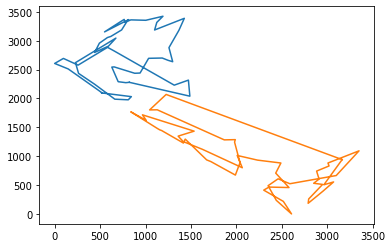

In [ ]:
values = []
min_value = np.inf
max_value = -np.inf
min_solution = []

matrix = distance_matrix(verticesB)

for i in range(0, 100):
  visited_1, visited_2 = greedy_nearest_neighbor(matrix, i)
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
draw_plot(matrix, min_solution)

### Testy dla rozbudowy cyklu

Min_value : 25428
Max_value : 29699
Average : 28225.95
Calculated min:  25428


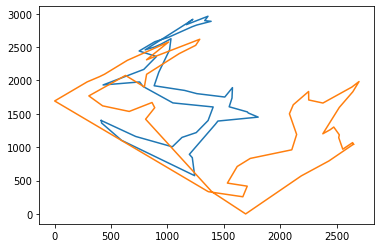

In [ ]:
values = []
min_value = np.inf
max_value = -np.inf
min_solution = []

matrix = distance_matrix(verticesA)

for i in range(0, 100):
  visited_1, visited_2 = greedy_cycle(matrix, i)
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
draw_plot(matrix, min_solution)

Min_value : 24423
Max_value : 29693
Average : 26830.04
Calculated min:  24423
[ 3  5 14 32 81 50 47 30 62 12 77 16 40 35 44 91 43 18 95 17 23 76 54 21
 22 87 53 46 80 78 64 36 71 57 83 51 42 59 73 65 86 88 49 15  1 41 63 13
 82  3] [66 69 52 38 39  9 67 20 94 28  7 98  2 10 92 27 90 96 75 58 31 97 11 70
 26 60 34 93 56  6 33  8 24 45  0 89 85 48 37 19 79 29 74 68 25 99 55 61
  4 66]


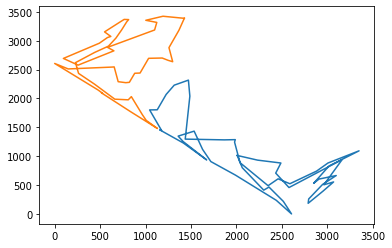

In [ ]:
values = []
min_value = np.inf
max_value = -np.inf
min_solution = []

matrix = distance_matrix(verticesB)

for i in range(0, 100):
  visited_1, visited_2 = greedy_cycle(matrix, i)
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Calculated min: ', calculate_cycle_length(matrix, [min_solution[0], min_solution[1]]))
print(min_solution[0], min_solution[1])
draw_plot(matrix, min_solution)

### Testy dla heurystyki z żalem

Min_value : 42547
Max_value : 58566
Average : 48628.74
Calculated min:  42547


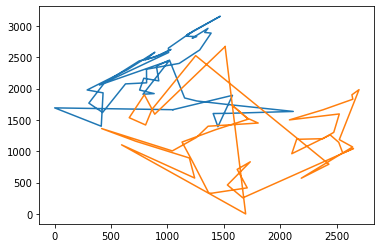

In [ ]:
values = []
min_value = np.inf
max_value = -np.inf
min_solution = []

matrix = distance_matrix(verticesA)

for i in range(0, 100):
  visited_1, visited_2 = greedy_regret(matrix, i)
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
draw_plot(matrix, min_solution)

Min_value : 39667
Max_value : 59454
Average : 48352.26
Calculated min:  39667


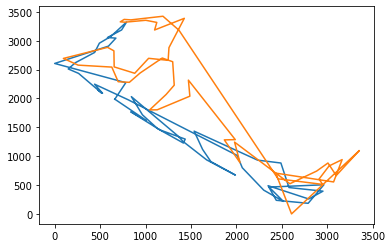

In [ ]:
values = []
min_value = np.inf
max_value = -np.inf
min_solution = []

matrix = distance_matrix(verticesB)

for i in range(0, 100):
  visited_1, visited_2 = greedy_regret(matrix, i)
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
draw_plot(matrix, min_solution)